In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
# Styling and plot setup
import matplotlib as mpl
mpl.rcParams.update({
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "legend.frameon": False,
    "font.size": 10,
})


In [39]:

# ============================
#  Bolthausen–Sznitman rates
# ============================

def lambda_bk(b, k):
    """
    Beta integral λ_{b,k} = ∫_0^1 x^{k-2} (1-x)^{b-k} dx = Beta(k-1, b-k+1).
    Note: r_{b,k} = C(b,k) * λ_{b,k} = b / (k (k-1)). This function is not
    needed for simulation once we use the closed form.
    """
    return math.exp(
        math.lgamma(k - 1)
        + math.lgamma(b - k + 1)
        - math.lgamma(b)
    )

def precompute_bs_rates(n_max):
    """
    Precompute for Bolthausen–Sznitman (Λ uniform on [0,1]):
      - total rates λ_b = b - 1 for b = 2,...,n_max
      - discrete distribution of merger sizes k with
          p(k|b) ∝ 1 / (k (k-1)),  k = 2,...,b

    Returns:
      lambdas[b] = λ_b
      probs[b]   = (k_values, cumulative_probabilities)
    """
    lambdas = np.zeros(n_max + 1)
    probs = {}

    for b in range(2, n_max + 1):
        # Exact total rate for BS
        lambdas[b] = b - 1.0

        # r_{b,k} = b / (k (k-1)) ⇒ probabilities ∝ 1/(k(k-1))
        ks = np.arange(2, b + 1)
        weights = 1.0 / (ks * (ks - 1))
        p = weights / weights.sum()
        cum_probs = np.cumsum(p)
        probs[b] = (ks, cum_probs)

    return lambdas, probs

def simulate_tmrca_bs(n, lambdas, probs, rng):
    """
    Simulate one TMRCA τ_n for Bolthausen–Sznitman coalescent
    using the block-counting process with Exp(λ_b) waiting times
    and merger size k drawn from p(k|b) above.

    Inputs:
      n        : sample size
      lambdas  : precomputed λ_b
      probs    : precomputed distributions of k given b
      rng      : NumPy random Generator
    """
    t = 0.0
    b = n
    while b > 1:
        rate = lambdas[b]
        # waiting time ~ Exp(rate)
        wait = rng.exponential(1.0 / rate)
        t += wait

        ks, cum_probs = probs[b]
        u = rng.random()
        idx = np.searchsorted(cum_probs, u)
        k = ks[idx]

        b = b - k + 1

    return t

# ============================
#  Gumbel density
# ============================

def gumbel_pdf(x):
    return np.exp(-x - np.exp(-x))

# ============================
#  Main experiment
# ============================

if __name__ == "__main__":
    rng = np.random.default_rng(1312)

    # --- paramètres pour la croissance en n ---
    n_list = np.array([10, 20, 50, 100, 200, 500, 1000,2000,5000,10000])
    n_max = int(n_list.max())
    n_rep = 500  # nombre de répétitions par n (augmenter si besoin)

    # pré-calcul des taux jusqu'à n_max
    lambdas, probs = precompute_bs_rates(n_max)

    # simulation des TMRCA moyens pour Bolthausen–Sznitman
    mean_tmrca_bs = []
    for n in n_list:
        vals = [simulate_tmrca_bs(n, lambdas, probs, rng) for _ in range(n_rep)]
        mean_tmrca_bs.append(np.mean(vals))
    mean_tmrca_bs = np.array(mean_tmrca_bs)

    # théorie Kingman: E[T_MRCA^(n)] = 2(1 - 1/n)
    mean_tmrca_kingman = 2.0 * (1.0 - 1.0 / n_list)

    # terme asymptotique log log n
    loglog_n = np.log(np.log(n_list)) + 0.5772156649015329  # Euler-Mascheroni constant

    # --- paramètres pour la convergence en loi (Gumbel) ---
    n_gumbel = 1000         # un n "grand"
    n_rep_gumbel = 5000     # nombre de répétitions pour l'histogramme

    # s'assurer que les taux jusqu'à n_gumbel sont pré-calculés
    if n_gumbel > n_max:
        lambdas, probs = precompute_bs_rates(n_gumbel)
        n_max = n_gumbel

    tmrca_samples = np.array([
        simulate_tmrca_bs(n_gumbel, lambdas, probs, rng)
        for _ in range(n_rep_gumbel)
    ])

    centered_samples = tmrca_samples - np.log(np.log(n_gumbel))


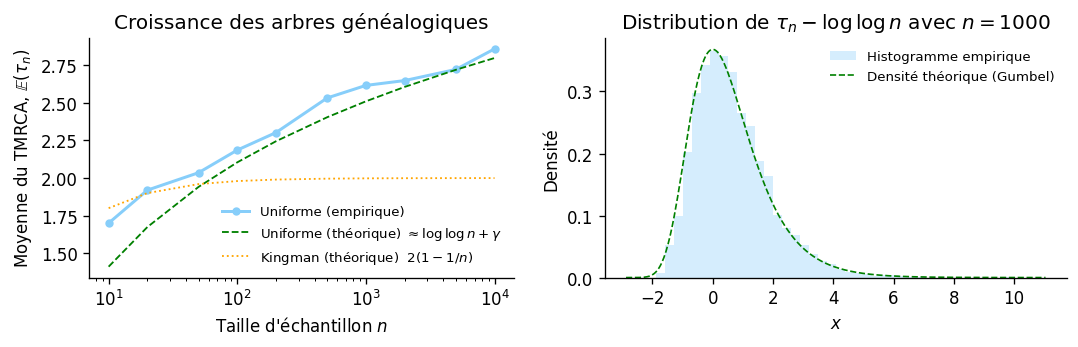

In [40]:
from matplotlib.gridspec import GridSpec

# ============================
#  Plots (clean, consistent)
# ============================

fig = plt.figure(figsize=(9, 3))
gs = GridSpec(1, 2, width_ratios=[1.15, 1.25])
ax_left = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[0, 1])

# Palette (align with other figs)
col_bs = "lightskyblue"
col_ref = "orange"
col_th = "green"

# --- Left: croissance de E[τ_n] ---
ax = ax_left
ax.plot(n_list, mean_tmrca_bs, marker="o", markersize=4, linewidth=1.8,
        color=col_bs, label=r"Uniforme (empirique)")
ax.plot(n_list, loglog_n, linestyle="--", linewidth=1.1,
        color=col_th, label=r"Uniforme (théorique) $\approx \log\log n + \gamma$")
ax.plot(n_list, mean_tmrca_kingman, linestyle=":", linewidth=1.1,
        color=col_ref, label=r"Kingman (théorique)  $2(1-1/n)$")

ax.set_xscale("log")
ax.set_xlabel(r"Taille d'échantillon $n$")
ax.set_ylabel(r"Moyenne du TMRCA, $\mathbb{E}(\tau_n)$")
ax.set_title("Croissance des arbres généalogiques")
ax.legend(fontsize=8)

# --- Right: convergence vers Gumbel ---
ax = ax_right
bins = 40
ax.hist(centered_samples, bins=bins, density=True, alpha=0.35,
        color=col_bs, label=r"Histogramme empirique")

x_vals = np.linspace(centered_samples.min() - 1.0,
                     centered_samples.max() + 1.0, 400)
ax.plot(x_vals, gumbel_pdf(x_vals), "--", linewidth=1.0,
        color=col_th, label="Densité théorique (Gumbel)")

ax.set_xlabel(r"$x$")
ax.set_ylabel("Densité")
# ax.set_title(fr"n = {n_gumbel}, $\tau_n - \log\log n \Rightarrow \mathcal{{G}}$")
ax.set_title(fr"Distribution de $\tau_n - \log\log n$ avec $n={n_gumbel}$")

ax.legend(fontsize=8)

fig.tight_layout()
plt.show()


In [41]:
out_svg = r"LaTeX/photo/plot_silence_ca_pousse.svg"
fig.savefig(out_svg)
